# <a>Content</a>

1. <a href="#1">Introduction</a>
2. <a href="#2">Image loading</a>
3. <a href="#3">ImageNet classes</a>
4. <a href="#4">Gradient ascent</a>
5. <a href="#5">Test some models</a>
 1. <a href="#51">VGG</a>
 2. <a href="#52">ResNet</a>
 3. <a href="#53">Inception v3</a>
6. <a href="#6">Conclusion</a>

# <a id="1">1. Introduction</a>

In recent years, deep learning has led to significant progress in AI. Particularly, in the field of computer vision, we have seen improvements in image classification, object detection, image segmentation, etc, which may suggest that neural networks "*see*" and "*understand*" images the way humans do. In fact, the input-output mapping that deep neural networks learn is profoundly different from human perception. In this notebook, we will present an experience that supports this point.

We will use the PyTorch library and some well known ImageNet classification models to show that even a powerful neural network can easily be trapped. We will build an image that appears to us to be definitely of some class, but that the model wrongly classifies as belonging to a class very far from the actual one.

<img src="https://serving.photos.photobox.com/57047823eb2d376694fc3ec03b5dfb9e0bb0933898ba22bb96ae5c0df66eed61b412f961.jpg"></img>
*Original image :* https://commons.wikimedia.org/wiki/File:Plume_the_Cat.JPG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch import optim
from torchvision import transforms, models
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

# <a id="2">2. Image loading</a>

<br />
First, let's define a function to download an image from the Internet and convert it to a PyTorch tensor that can be fed to our models.

In [2]:
from PIL import Image
from io import BytesIO
import requests


def load_image(img_path, max_size=224):
    # Download the image
    response = requests.get(img_path)
    image = Image.open(BytesIO(response.content)).convert(
        "RGB"
    )

    # Resize and normalize the image
    size = min(max_size, max(image.size))
    img_transforms = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize(
                (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
            ),
        ]
    )

    # Don't forget to add the batch dimension
    return img_transforms(image).unsqueeze(0)

Let's also define a function to plot tensor images.

In [3]:
def plot_image(image, title=""):
    image = image.to("cpu").detach().numpy()
    image = image.squeeze().transpose(1, 2, 0)

    # Denormalize the image
    image = image * np.array(
        (0.229, 0.224, 0.225)
    ) + np.array((0.485, 0.456, 0.406))
    
    image = image.clip(0, 1)

    plt.imshow(image)
    plt.title(title)

torch.Size([1, 3, 224, 336])


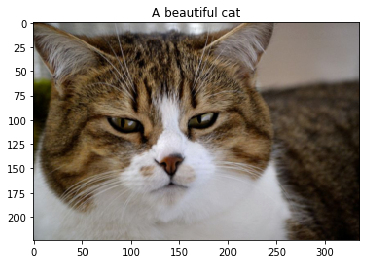

In [4]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Plume_the_Cat.JPG/800px-Plume_the_Cat.JPG"
image = load_image(img_path)

print(image.shape)
plot_image(image, "A beautiful cat")

# <a id="3">3. ImageNet classes</a>

<br />
For us to understand the predictions of the models, we will need the mapping between class IDs and class names of the ImageNet dataset. The method used to get the mapping can be found here : [https://discuss.pytorch.org/t/imagenet-classes/4923/3](https://discuss.pytorch.org/t/imagenet-classes/4923/3).

In [5]:
from urllib.request import urlretrieve
import json

classes_url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
classes_path = "imagenet_class_index.json"
urlretrieve(classes_url, classes_path)

class_idx = json.load(open(classes_path))
idx2label = [
    class_idx[str(k)][1] for k in range(len(class_idx))
]

In [6]:
print(idx2label[:5])

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']


# <a id="4">4. Gradient ascent</a>

<br />
Gradient ascent is the same as gradient descent, but instead of minimizing a function, we maximize it. Recall that we want to build an image that a given model will totally fail to classify. One method to do that is to take an initial image that the model classifies well, freeze the weights of the model and maximize the output score of some class. In other words, we do classical gradient descent optimization with some differences :

1. The weights of the model are freezed, so the model doesn't get updated.
2. The parameters to optimize are the pixels of the initial image.
3. The loss function is the score of some given class.
4. We do maximization instead of minimization.

For example, if we take the image of a cat and we want to make the model predict that it's a dog, we do gradient ascient to maximize the score of the class *dog* given the initial image of the cat.

The following function is an implementation of this procedure. It takes as input a model, an initial image, the class to maximize, a configured optimizer and the number of iterations. At each iteration, it executes a forward pass through the network, and updates the initial image according to the calculated loss. The loss here is negative the score of the given class, in order to the maximization instead of minimization.

In [7]:
def gradient_ascent(
    model, new_img, new_class, opt, n_epochs, print_every
):
    for epoch in range(n_epochs):
        output = F.softmax(model(new_img), dim=1)
        loss = -output[0, new_class]

        opt.zero_grad()
        loss.backward()
        opt.step()

        if epoch % print_every == 0:
            print(
                "Epoch :", epoch + 1, "Loss :", -loss.item()
            )


# <a id="5">5. Test some models</a>

<br />
So, this is what you came here for. In this section, we will trap three well known ImageNet models : **VGG**, **ResNet** and **Inception v3**. In all cases, we will use gradient ascent to slightly modify an image to make it look (at least for the model) totally different.

In [8]:
# A helper function to make predictions
def make_predictions(model, img, topk=5):
    preds = F.softmax(model(img), dim=1)
    probs, classes = preds.topk(topk, dim=1)

    probs, classes = probs.to("cpu"), classes.to("cpu")

    for i, c in enumerate(classes[0]):
        print(
            idx2label[c],
            "with probability",
            probs[0, i].item(),
        )

## <a id="51">A. VGG</a>

<br />
Let's download an image, load the model, freeze all its parameters and turn it to evaluation mode.

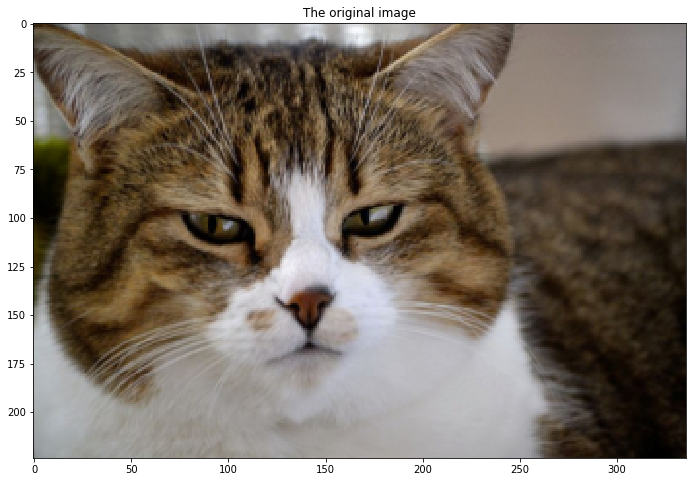

In [9]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Plume_the_Cat.JPG/800px-Plume_the_Cat.JPG"
cat_img = load_image(img_path).to(device)

plt.figure(figsize=(15, 8))
plot_image(cat_img, "The original image")

*Image source :* [https://commons.wikimedia.org/wiki/File:Plume_the_Cat.JPG](https://commons.wikimedia.org/wiki/File:Plume_the_Cat.JPG)

In [10]:
model = models.vgg19(pretrained=True).to(device)
for param in model.parameters():
    model.requires_grad = False

model = model.eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /tmp/.torch/models/vgg19-dcbb9e9d.pth
574673361it [00:26, 22057625.17it/s]


In [11]:
make_predictions(model, cat_img)

tiger_cat with probability 0.784152090549469
tabby with probability 0.161953404545784
Egyptian_cat with probability 0.04843280091881752
lynx with probability 0.0024119135923683643
ping-pong_ball with probability 0.0003912121173925698


Well, I don't know if it's actually a tiger cat, but the model correctly classified the image as being of a cat.

Let's do some gradient ascent. We will try to modify the image to make the network predict that it's a computer keyboard. So we will get the ID associated to the class "computer keyboard", define an optimizer and call our gradient ascent routine.

In [12]:
new_class = idx2label.index("computer_keyboard")

new_img = cat_img.clone()
new_img.requires_grad = True

# The optimizer parameters are the pixels of the initial image
opt = optim.Adam([new_img], lr=0.01)
n_epochs = 5
print_every = 1

gradient_ascent(
    model, new_img, new_class, opt, n_epochs, print_every
)

Epoch : 1 Loss : 3.112983540631831e-05
Epoch : 2 Loss : 0.009192084893584251
Epoch : 3 Loss : 0.13288259506225586
Epoch : 4 Loss : 0.5330795049667358
Epoch : 5 Loss : 0.850034236907959


Few iterations suffice to achieve a huge score on the new class. But how does the image look like now ?

computer_keyboard with probability 0.9477413892745972
mouse with probability 0.028052568435668945
laptop with probability 0.009765724651515484
tiger_cat with probability 0.0037263750564306974
printer with probability 0.002404575003311038


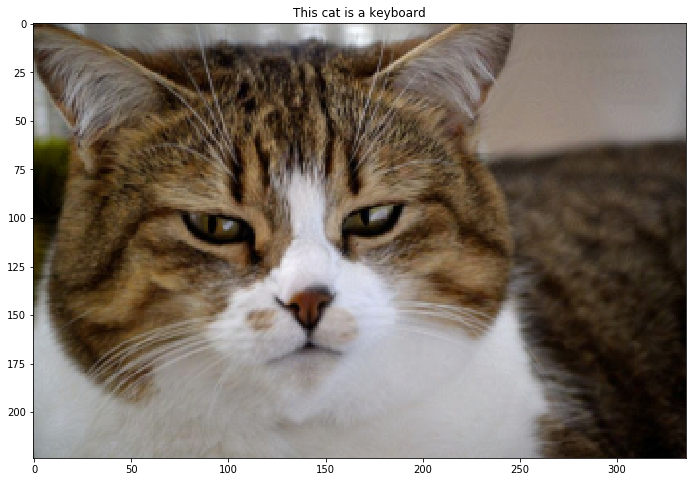

In [13]:
make_predictions(model, new_img)

plt.figure(figsize=(15, 8))
plot_image(new_img, "This cat is a keyboard")

As you see, the model now predicts that the image is a keyboard with high probability, so the model is very confident. Looking at the new image, a human sees no difference with the original and sees no keyboard on it. But the model is highly confident that the image represents a keyboard. I think that this shows a significant and profound difference between how a human process images and how a neural network does.

## <a id="52">B. ResNet</a>

<br />
The same method is used here for a ResNet model, although we use an image of a panda. I know that I should have written functions to avoid redundant code, but I think it's easier to follow the different steps like this.

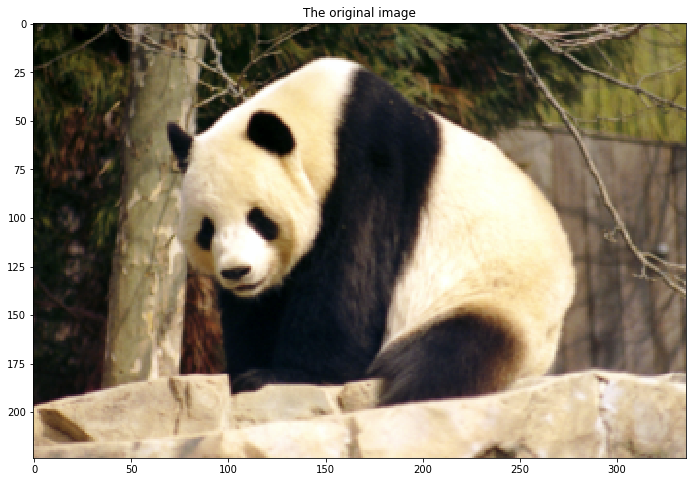

In [14]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/3/3c/Giant_Panda_2004-03-2.jpg"
pd_img = load_image(img_path).to(device)

plt.figure(figsize=(15, 8))
plot_image(pd_img, "The original image")

In [15]:
model = models.resnet152(pretrained=True).to(device)
for param in model.parameters():
    model.requires_grad = False

model = model.eval()

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /tmp/.torch/models/resnet152-b121ed2d.pth
241530880it [00:06, 37683865.94it/s]


In [16]:
make_predictions(model, pd_img)

giant_panda with probability 0.9335780739784241
lesser_panda with probability 0.01059756614267826
brown_bear with probability 0.009922429919242859
American_black_bear with probability 0.005555966403335333
ice_bear with probability 0.005138159263879061


In [17]:
new_class = idx2label.index("banana")

new_img = pd_img.clone()
new_img.requires_grad = True

opt = optim.Adam([new_img], lr=0.01)
n_epochs = 6
print_every = 1

gradient_ascent(
    model, new_img, new_class, opt, n_epochs, print_every
)

Epoch : 1 Loss : 6.201566066010855e-06
Epoch : 2 Loss : 5.7919794926419854e-05
Epoch : 3 Loss : 0.0012632474536076188
Epoch : 4 Loss : 0.027137640863656998
Epoch : 5 Loss : 0.31827670335769653
Epoch : 6 Loss : 0.8913013339042664


banana with probability 0.990304708480835
pineapple with probability 0.003015466732904315
custard_apple with probability 0.0012008324265480042
corn with probability 0.000719397037755698
lemon with probability 0.0005556467804126441


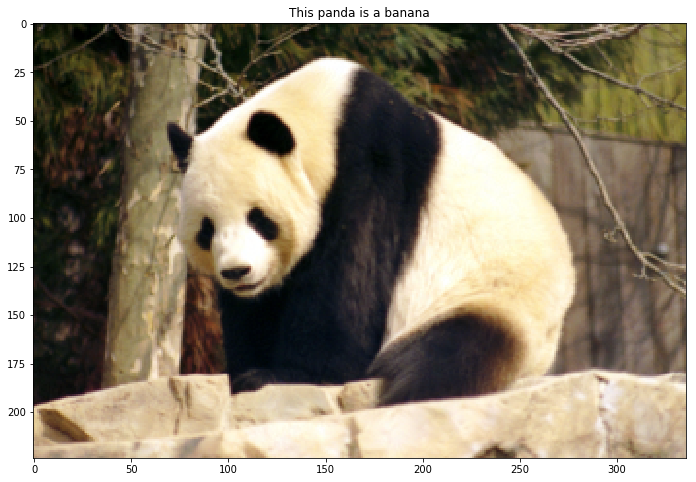

In [18]:
make_predictions(model, new_img)

plt.figure(figsize=(15, 8))
plot_image(new_img, "This panda is a banana")

## <a id="53">C. Inception v3</a>

<br />
Time for inception, with apples this time.

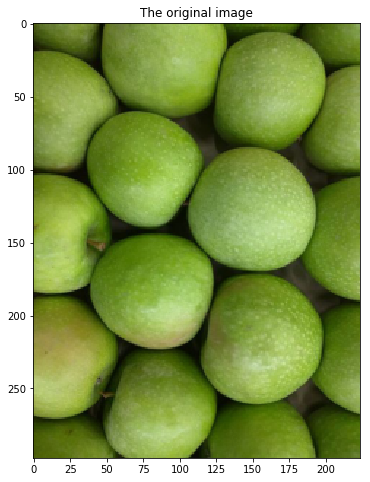

In [19]:
img_path = "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Granny_smith.jpg/450px-Granny_smith.jpg"
apple_img = load_image(img_path).to(device)

plt.figure(figsize=(15, 8))
plot_image(apple_img, "The original image")

*Image source : * [https://commons.wikimedia.org/wiki/File:Granny_smith.jpg](https://commons.wikimedia.org/wiki/File:Granny_smith.jpg)

In [20]:
model = models.inception_v3(pretrained=True).to(device)
for param in model.parameters():
    model.requires_grad = False

model = model.eval()

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /tmp/.torch/models/inception_v3_google-1a9a5a14.pth
108857766it [00:05, 21669980.33it/s]


In [21]:
make_predictions(model, apple_img)

Granny_Smith with probability 0.9999697208404541
bikini with probability 1.0316800398868509e-05
lemon with probability 2.941319735327852e-06
banana with probability 1.0010467121901456e-06
fig with probability 5.879896889382508e-07


In [22]:
new_class = idx2label.index("lion")

new_img = apple_img.clone()
new_img.requires_grad = True

opt = optim.Adam([new_img], lr=0.01)
n_epochs = 51
print_every = 5

gradient_ascent(
    model, new_img, new_class, opt, n_epochs, print_every
)

Epoch : 1 Loss : 5.63159652244849e-09
Epoch : 6 Loss : 5.994680751797432e-09
Epoch : 11 Loss : 6.687938203242538e-09
Epoch : 16 Loss : 7.797410717103048e-09
Epoch : 21 Loss : 9.627530772604587e-09
Epoch : 26 Loss : 1.296043894427612e-08
Epoch : 31 Loss : 2.0252135968235052e-08
Epoch : 36 Loss : 4.0894814645753286e-08
Epoch : 41 Loss : 2.1704498465169308e-07
Epoch : 46 Loss : 0.01403458695858717
Epoch : 51 Loss : 0.9775058031082153


Well, here we need more iterations to make the apples look like lions, but nothing impossible.

lion with probability 0.9863242506980896
cheetah with probability 0.0014698724262416363
bathing_cap with probability 0.0007971485611051321
cougar with probability 0.0007540383376181126
lynx with probability 0.0006143574137240648


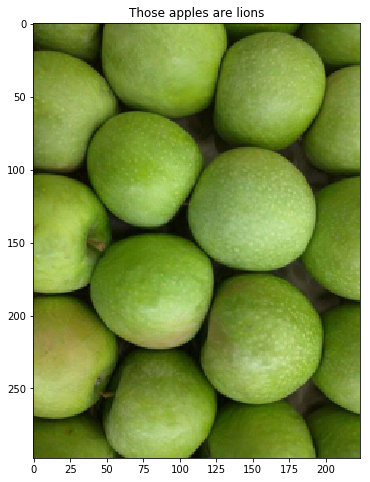

In [23]:
make_predictions(model, new_img)

plt.figure(figsize=(15, 8))
plot_image(new_img, "Those apples are lions")

# <a id="6">6. Conclusion</a>

<br />
As we have seen, neural networks can easily be trapped to misclassify images. The way that this was achieved shows that even though neural networks are powerful models that achieve state-of-the-art performances in different perception tasks, it's important to think twice about the predictions they make, and to avoid misinterpreting or overinterpreting the way they work. 

If you are interested in the limitations of deep learning, you can find an interesting discussion in the last chapter of the book : *Deep Learning with Python by François Cholet*.

This is my first public kernel, so please let me know if you have some remarks or found some mistakes.